# Automated rule-based Bayesian regression analysis for the linear regression data

Load the packages

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("ggplot")

import json

WARNING (theano.configdefaults): We are not able to detect the number of CPU cores. We disable openmp by default. To remove this warning, set the environment variable OMP_NUM_THREADS to the number of threads you want theano to use.


Create the data

In [2]:
sample_size = 500
random_num_generator = np.random.RandomState(0)
x_all = 10.0 * random_num_generator.rand(sample_size)
df_allx = pd.Series(x_all)
df_x = df_allx[df_allx.between(4, 5)]

sigma_e = 3.0
e = random_num_generator.normal(0, sigma_e, len(df_allx))
df_ally = 1.0 + 2.0 * df_allx + e  # a = 1.0; b = 2.0; y = a + b*x
df_y = df_ally[df_allx.between(4, 5)]

Plot the data

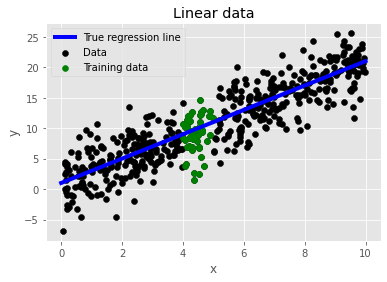

In [3]:
fig, ax = plt.subplots()
ax.scatter(df_allx, df_ally, c="k", label="Data")
ax.scatter(df_x, df_y, c="g", label="Training data")
ax.plot([0, 10], [1, 21], c="b", linewidth=4, label="True regression line")
ax.set_xlabel("Predictor")
ax.set_ylabel("Label")
ax.set_title("Linear data")
ax.legend(ncol=2, fontsize=10)
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.legend()

#fig.savefig("linear_data", dpi=300)

Save the data

In [4]:
x_all = df_allx.to_numpy()
y_all = df_ally.to_numpy()

x = df_x.to_numpy()
y = df_y.to_numpy()

data = {}
data["x_all"] = df_allx.to_json(orient="values")
data["y_all"] = df_ally.to_json(orient="values")
data["x"] = df_x.to_json(orient="values")
data["y"] = df_y.to_json(orient="values")

#with open("data_linear.txt", "w") as outfile:
#    json.dump(data, outfile)

## Bayesian linear regression

Run the model

In [5]:
np.random.seed(123)

with pm.Model() as model_norule:
    # define priors
    x_co = pm.Normal("x_co", 0.0, 10.0)
    b = pm.Normal("intercept", 0, 10.0)
    s = pm.Exponential("error", 1)

    res = x_co * x + b

    # predictions
    obs = pm.Normal("observation", res, s, observed=y,)

with model_norule:
    step = pm.Metropolis(scaling=10)
    trace_norule = pm.sample(draws=100000, step=step, tune=20000, cores=1, chains=2)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [error]
>Metropolis: [intercept]
>Metropolis: [x_co]
Sampling chain 1, 0 divergences: 100%|██████████| 120000/120000 [00:33<00:00, 3553.03it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


Print the posterior summary statistics

In [6]:
print(trace_norule["intercept"].mean())
print(trace_norule["intercept"].std())
print(trace_norule["x_co"].mean())
print(trace_norule["x_co"].std())

-2.198048091974744
5.738837774246837
2.529109170889243
1.2956770133255053


Take posterior samples and evaluate the posterior mean

In [7]:
mu_pp = (
    trace_norule["intercept"][::100]
    + trace_norule["x_co"][::100] * x_all.reshape(-1, 1)
).T

map = trace_norule["intercept"].mean() + trace_norule["x_co"].mean() * x_all.reshape(
    -1, 1
)

Plot the posterior

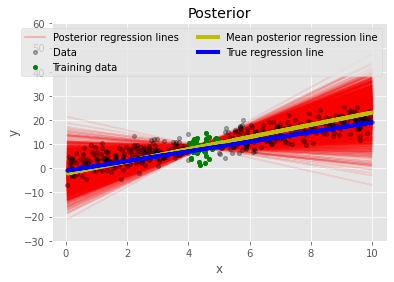

In [8]:
fig, ax = plt.subplots()

for j in range(mu_pp.shape[0]):
    ax.plot(x_all, mu_pp[j], alpha=0.1, c="r")
ax.plot(x_all, mu_pp[1], alpha=0.3, c="r", label="Posterior regression lines")

ax.plot(df_allx, df_ally, "o", ms=4, alpha=0.3, c="k", label="Data")
ax.plot(x, y, "o", ms=4, c="g", label="Training data")
ax.plot(
    x_all, map.reshape(-1), c="y", linewidth=4, label="Mean posterior regression line"
)
ax.plot(x_all, -1 + 2 * x_all, c="b", linewidth=4, label="True regression line")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Posterior")
plt.ylim([-30, 60])
ax.legend(ncol=2, fontsize=10)

#fig.savefig("linear_norule.png", dpi=300)

Evaluate metrics

In [9]:
mse = mean_squared_error(map.reshape(-1), x_all)
mae = mean_absolute_error(map.reshape(-1), x_all)

rule_waic = az.waic(trace_norule, model_norule, scale="deviance")

with open("metrics.txt", "w") as text_file:
    print("Metrics linear (no rules)", file=text_file)
    print(f"mse: {mse}", file=text_file)
    print(f"mae: {mae}", file=text_file)
    print(f"waic: {rule_waic.waic}", file=text_file)

/usr/local/anaconda3/envs/burgers/lib/python3.7/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


## Rule-based Bayesian linear regression (proportion rules)

Define the rule function

In [10]:
np.random.seed(123)

no_points = 25
xlow = min(x)
xmid = 4.8
xhi = max(x)

rule_first = np.linspace(xlow, xmid, no_points)
rule_second = np.linspace(xmid, xhi, no_points)

ymid = 10.65


def logp_rule_nopm(
    x_co, b_lat,
):

    points_r1 = rule_first * x_co + b_lat
    points_r2 = rule_second * x_co + b_lat

    rule_log_lik = 0
    for i in range(no_points):
        rule_log_lik = rule_log_lik + pm.math.switch(
            pm.math.gt(points_r1[i], ymid), 1, 0
        )
        rule_log_lik = rule_log_lik + pm.math.switch(
            pm.math.lt(points_r2[i], ymid), 1, 0
        )

    rule_ratio = rule_log_lik / (2 * no_points)

    return pm.Beta.dist(alpha=1.0, beta=1000.0).logp(rule_ratio)

Run the model

In [11]:
with pm.Model() as model_rule:
    # define priors
    x_co = pm.Normal("x_co", 0.0, 10.0)
    b = pm.Normal("intercept", 0, 10.0)
    s = pm.Exponential("error", 1)

    b_lat = pm.Normal("intercept_lat", 0, 10.0)

    res = x_co * x + b

    # predictions
    obs = pm.Normal("observation", res, s, observed=y,)
    LL_rule = pm.Potential("LL_rule", logp_rule_nopm(x_co, b_lat))

with model_rule:
    step = pm.Metropolis(scaling=10)
    trace_rule = pm.sample(draws=200000, step=step, tune=200000, cores=1, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [intercept_lat]
>Metropolis: [error]
>Metropolis: [intercept]
>Metropolis: [x_co]
Sampling chain 0, 0 divergences: 100%|██████████| 120000/120000 [00:59<00:00, 2016.89it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Print the posterior summary statistics

In [12]:
print(trace_rule["intercept"].mean())
print(trace_rule["intercept"].std())
print(trace_rule["x_co"].mean())
print(trace_rule["x_co"].std())

5.541051617833718
0.6638129159786527
0.7778050550563201
0.11398306399629096


Take posterior samples and evaluate the posterior mean

In [13]:
mu_pp = (
    trace_rule["intercept"][::100] + trace_rule["x_co"][::100] * x_all.reshape(-1, 1)
).T

map = trace_rule["intercept"].mean() + trace_rule["x_co"].mean() * x_all.reshape(-1, 1)

Plot the posterior

(-30.0, 60.0)

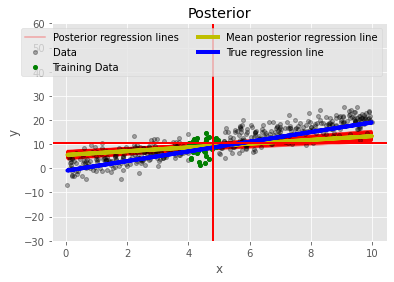

In [14]:
fig, ax = plt.subplots()

for j in range(mu_pp.shape[0]):
    ax.plot(x_all, mu_pp[j], alpha=0.3, c="r")
ax.plot(x_all, mu_pp[1], alpha=0.3, c="r", label="Posterior regression lines")
ax.plot(
    x_all, y_all, "o", alpha=0.3, ms=4, c="k", label="Data",
)
ax.plot(
    x, y, "o", ms=4, label="Training Data", color="g",
)
ax.plot(
    x_all, map.reshape(-1), c="y", linewidth=4, label="Mean posterior regression line"
)
ax.plot(x_all, -1 + 2 * x_all, c="b", linewidth=4, label="True regression line")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Posterior")
ax.legend(ncol=2, fontsize=10)
plt.axvline(xmid, c="red", linewidth=2)
plt.axhline(ymid, c="red", linewidth=2)
plt.ylim([-30, 60])
#fig.savefig("linear_rule.png", dpi=300)

Evaluate metrics

In [15]:
mse = mean_squared_error(map.reshape(-1), x_all)
mae = mean_absolute_error(map.reshape(-1), x_all)

rule_waic = az.waic(trace_rule, model_rule, scale="deviance")

with open("metrics.txt", "a") as text_file:
    print("Metrics linear (proportion rules)", file=text_file)
    print(f"mse: {mse}", file=text_file)
    print(f"mae: {mae}", file=text_file)
    print(f"waic: {rule_waic.waic}", file=text_file)

/usr/local/anaconda3/envs/burgers/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (100000) than draws (4). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/usr/local/anaconda3/envs/burgers/lib/python3.7/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


## Rule-based Bayesian linear regression (total distance rules)

Define the rule function

In [16]:
np.random.seed(456)

no_points = 25
xlow = min(x)
xmid = 4.85
xhi = max(x)

rule_first = np.linspace(xlow, xmid, no_points)
rule_second = np.linspace(xmid, xhi, no_points)

ymid = 11.0


def logp_rule_nopm(
    x_co, b_lat,
):

    points_r1 = rule_first * x_co + b_lat
    points_r2 = rule_second * x_co + b_lat

    rule_log_lik = 0
    for i in range(no_points):
        rule_log_lik = rule_log_lik + pm.math.switch(
            pm.math.gt(points_r1[i], ymid),
            pm.math.sqrt(pm.math.sqr(points_r1[i] - ymid)),
            0,
        )
        rule_log_lik = rule_log_lik + pm.math.switch(
            pm.math.lt(points_r2[i], ymid),
            pm.math.sqrt(pm.math.sqr(points_r2[i] - ymid)),
            0,
        )

    return pm.Exponential.dist(10).logp(rule_log_lik)

Run the model

In [17]:
with pm.Model() as model_rule:
    # define priors
    x_co = pm.Normal("x_co", 0.0, 10.0)
    b = pm.Normal("intercept", 0, 10.0)
    s = pm.Exponential("error", 1)

    b_lat = pm.Normal("intercept_lat", 0, 10.0)

    res = x_co * x + b

    # predictions
    obs = pm.Normal("observation", res, s, observed=y,)
    LL_rule = pm.Potential("LL_rule", logp_rule_nopm(x_co, b_lat))

with model_rule:
    step = pm.Metropolis(scaling=10)
    trace_rule = pm.sample(draws=200000, step=step, tune=200000, cores=1, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [intercept_lat]
>Metropolis: [error]
>Metropolis: [intercept]
>Metropolis: [x_co]
Sampling chain 0, 0 divergences: 100%|██████████| 120000/120000 [00:59<00:00, 2028.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Print the posterior summary statistics

In [18]:
print(trace_rule["intercept"].mean())
print(trace_rule["intercept"].std())
print(trace_rule["x_co"].mean())
print(trace_rule["x_co"].std())

-5.413462136708462
5.642003095211051
3.2568663768653803
1.2735641400811548


Take posterior samples and evaluate the posterior mean

In [19]:
mu_pp = (
    trace_rule["intercept"][::100] + trace_rule["x_co"][::100] * x_all.reshape(-1, 1)
).T

map = trace_rule["intercept"].mean() + trace_rule["x_co"].mean() * x_all.reshape(-1, 1)

Plot the posterior

(-30.0, 60.0)

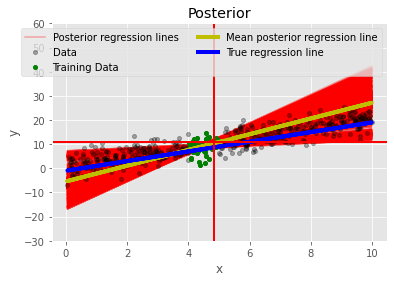

In [20]:
fig, ax = plt.subplots()

for j in range(mu_pp.shape[0]):
    ax.plot(x_all, mu_pp[j], alpha=0.3, c="r")
ax.plot(x_all, mu_pp[1], alpha=0.3, c="r", label="Posterior regression lines")
ax.plot(
    x_all, y_all, "o", ms=4, alpha=0.3, c="k", label="Data",
)
ax.plot(
    x, y, "o", ms=4, label="Training Data", color="g",
)
ax.plot(
    x_all, map.reshape(-1), c="y", linewidth=4, label="Mean posterior regression line"
)
ax.plot(x_all, -1 + 2 * x_all, c="b", linewidth=4, label="True regression line")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Posterior")
ax.legend(ncol=2, fontsize=10)
plt.axvline(xmid, c="red", linewidth=2)
plt.axhline(ymid, c="red", linewidth=2)
plt.ylim([-30, 60])
#fig.savefig("linear_rule_d.png", dpi=300)

Evaluate metrics

In [21]:
mse = mean_squared_error(map.reshape(-1), x_all)
mae = mean_absolute_error(map.reshape(-1), x_all)

rule_waic = az.waic(trace_rule, model_rule, scale="deviance")

with open("metrics.txt", "a") as text_file:
    print("Metrics linear (total distance rules)", file=text_file)
    print(f"mse: {mse}", file=text_file)
    print(f"mae: {mae}", file=text_file)
    print(f"waic: {rule_waic.waic}", file=text_file)

/usr/local/anaconda3/envs/burgers/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (100000) than draws (4). Passed array should have shape (chains, draws, *shape)
  UserWarning,
